# Titanic 

In [2]:
!unzip -n titanic.zip 

Archive:  titanic.zip


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import math

In [4]:
train_path = "train.csv"
test_path = "test.csv"
ss_path = "gender_submission.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
ss = pd.read_csv(ss_path)

In [5]:
# Pandas's latest magic: converts data from object type into their responsible types while handling None values as pd.NA (even for strings)
train = train.convert_dtypes(dtype_backend="numpy_nullable")
test = test.convert_dtypes(dtype_backend="numpy_nullable")

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,<NA>,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,<NA>,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,<NA>,S


In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,<NA>,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0,<NA>,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,<NA>,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,<NA>,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,<NA>,S


In [8]:
ss.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## EDA

In [9]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
# Extract feature columns
all_columns = train.columns
removeable_columns = ["PassengerId", "Survived"]
feature_columns = list(set(all_columns) - set(removeable_columns))

new_columns = [] # I will be adding newly engineered columns that I will add to train and test

col_types = {}
for col in all_columns:
    dtype = train[col].dtype
    dtype = str(dtype).lower()
    col_types[col] = dtype


### Missing Data

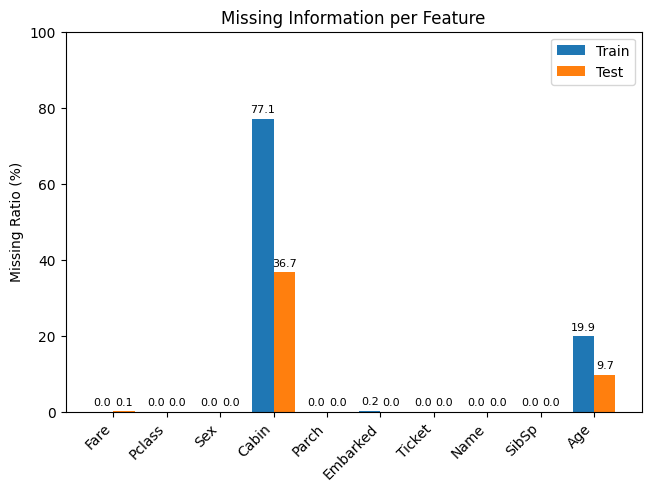

In [11]:
def missing_data_bar_plot(cols=feature_columns):
    # Calculate the missing ratios
    n = len(train)
    train_missing_ratio, test_missing_ratio = {}, {}
    for col in cols:
        train_missing_ratio[col] = sum(train[col].isna()) / n * 100
        test_missing_ratio[col] = sum(test[col].isna()) / n * 100


    # Plot the ratios

    x = np.arange(len(cols))
    bar_width = 0.4

    # values
    train_ratios = [train_missing_ratio[col] for col in cols]
    test_ratios = [test_missing_ratio[col] for col in cols]

    # Diagram objects
    fig, ax = plt.subplots(layout="constrained")

    rects1 = ax.bar(x-bar_width/2, train_ratios, bar_width, label="Train") # Train on the left
    rects2 = ax.bar(x+bar_width/2, test_ratios, bar_width, label="Test") # Test on the right 

    # labels on bars
    ax.bar_label(rects1, padding=3, fontsize=8, fmt="%.1f")
    ax.bar_label(rects2, padding=3, fontsize=8, fmt="%.1f")

    # axis labels & formatting
    ax.set_ylabel("Missing Ratio (%)")
    ax.set_xticks(x)
    ax.set_xticklabels(cols, rotation=45, ha="right")
    ax.set_title("Missing Information per Feature")
    ax.set_ylim(0, 100)
    ax.legend()

    plt.show()

missing_data_bar_plot()

## Categorical Columns

In [12]:
cat_threshold = 10
cat_columns = []

for col in feature_columns:
    if train[col].nunique() < cat_threshold:
        cat_columns.append(col)

cat_columns

['Pclass', 'Sex', 'Parch', 'Embarked', 'SibSp']

In [13]:
def plot_cat_cols(df: pd.DataFrame, cols: list, ncols: int = 3, show_pct=True):
    """
    Plots pie charts for multiple categorical columns in a grid layout.
    
    Args:
        df: pandas DataFrame
        cols: list of column names
        ncols: number of columns in the subplot grid
        show_pct: whether to display percentages on the pie chart
    """
    nplots = len(cols)
    nrows = math.ceil(nplots / ncols)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), layout="constrained")
    axes = axes.flatten()  # flatten in case of multiple rows
    
    for i, col in enumerate(cols):
        ax = axes[i]
        data = df[col].value_counts(dropna=True)
        labels = data.index.astype(str)
        values = data.values
        
        ax.pie(
            values, 
            labels=labels, 
            autopct="%1.1f%%" if show_pct else None,
            startangle=90,
            counterclock=False
        )
        ax.set_title(col)
    
    # Turn off any empty subplots
    for j in range(nplots, len(axes)):
        axes[j].axis("off")
    
    plt.show()


### Categorical Data Distribution Plots [Train]

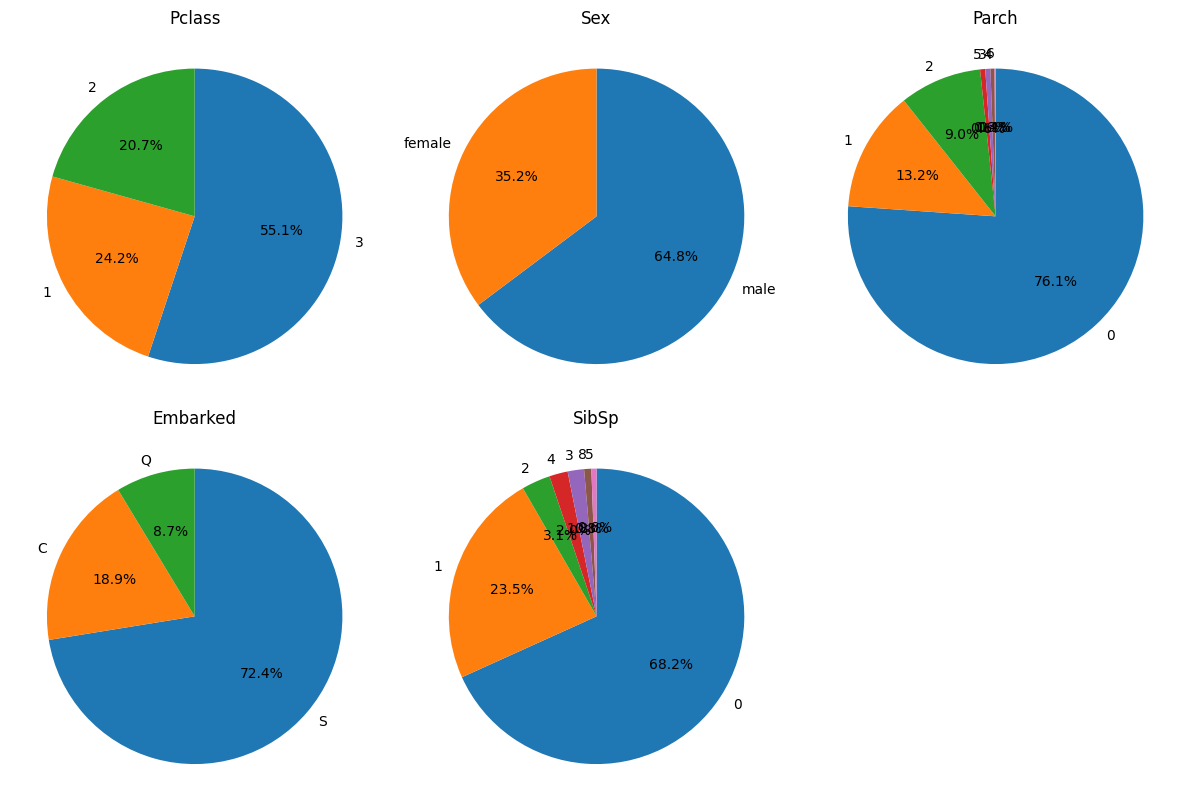

In [14]:
plot_cat_cols(train, cat_columns)

### Categorical Data Distribution Plots [Test]

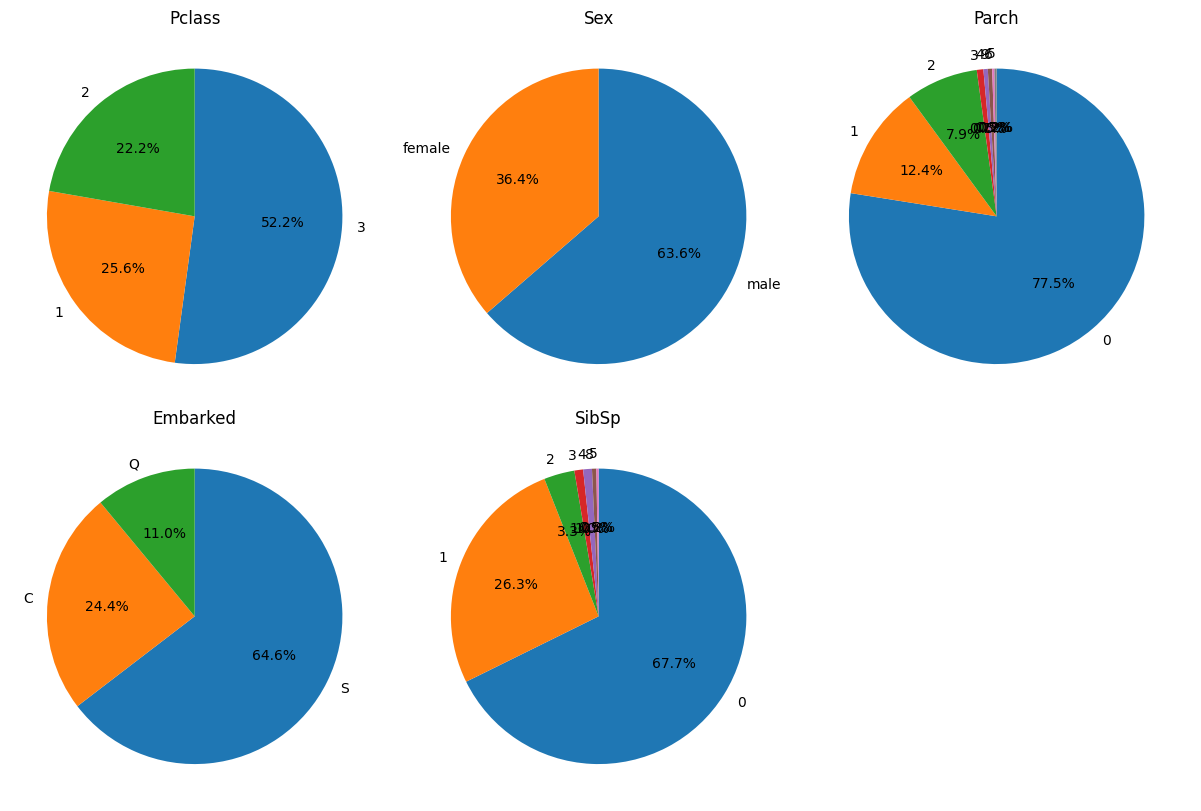

In [15]:
plot_cat_cols(test, cat_columns)

## Continuous Data

In [16]:
continuous_columns = []
for col in feature_columns:
    if col not in cat_columns:
        if "float" in col_types[col]:
            continuous_columns.append(col)

In [17]:
def plot_continuous_cols(df: pd.DataFrame, cols: list, ncols: int = 3, bins: int = 30):
    """
    Plots histograms with KDE overlay for multiple continuous columns in a grid layout.
    
    Args:
        df: pandas DataFrame
        cols: list of continuous column names
        ncols: number of columns in the subplot grid
        bins: number of bins for histograms
    """
    nplots = len(cols)
    nrows = math.ceil(nplots / ncols)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), layout="constrained")
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        ax = axes[i]
        series = df[col].dropna()
        
        ax.hist(series, bins=bins, alpha=0.7, edgecolor="black")
        ax.set_title(col)
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
    
    # Hide unused subplots
    for j in range(nplots, len(axes)):
        axes[j].axis("off")
    
    plt.show()

### Continuous Data Distributions [Train]

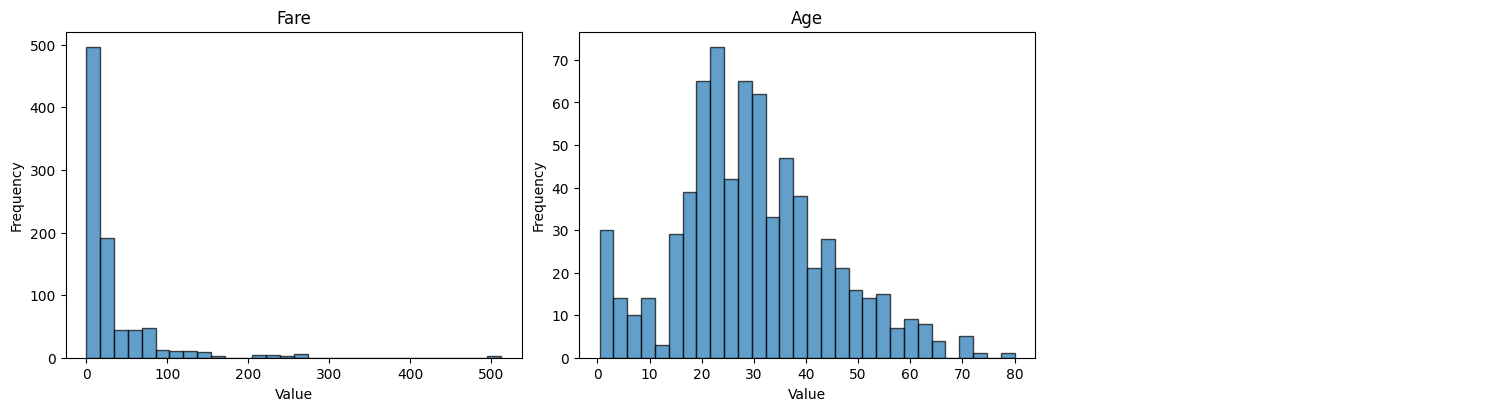

In [18]:
plot_continuous_cols(train, continuous_columns)

### Continuous Data Distributions [Test]

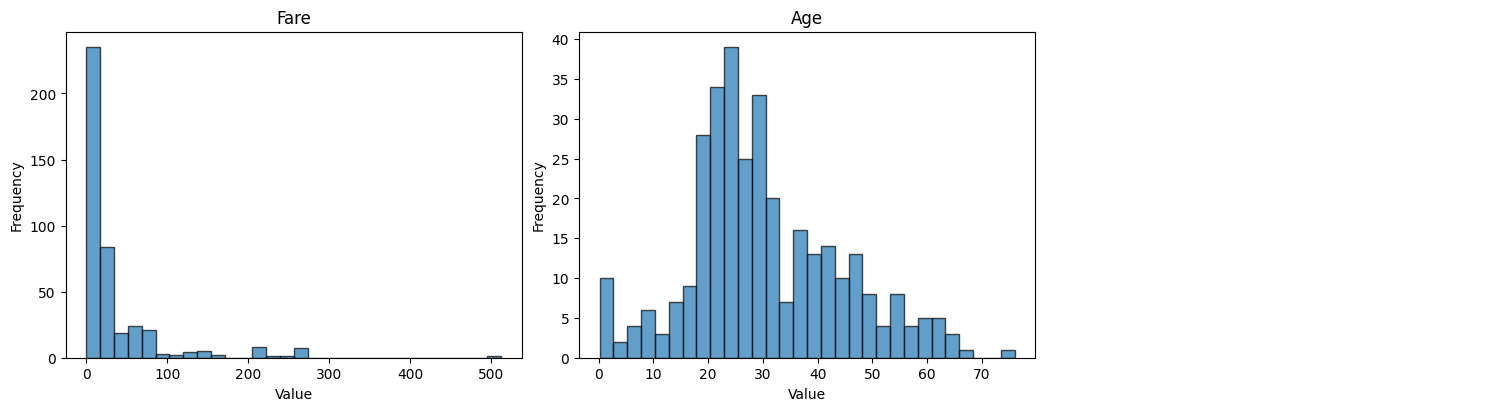

In [19]:
plot_continuous_cols(test, continuous_columns)

## String Data

In [20]:
string_columns = []
for col in feature_columns:
    if col not in cat_columns and col not in continuous_columns: 
        if ("str" in col_types[col]):
            string_columns.append(col)

assert len(cat_columns) + len(continuous_columns) + len(string_columns) == len(feature_columns), "Unresolved Column Types"

### Cabin (A letter followed by numbers)
I guess letters indicate the section of the ship and the number indicates the seat number or row of the seated passengers

In [21]:
def extract_cabin_letter(df: pd.DataFrame, return_erroric=False):
    """
    Extract the first letter of the Cabin column if it's a valid English letter.
    Returns a new Series.
    """

    erroric = []
    letters = []

    for i in range(len(df)):
        cabin = df["Cabin"][i]
        if pd.isna(cabin):
            letters.append(None)
        else:
            first_char = str(cabin)[0]
            if first_char.isalpha():
                letters.append(first_char)
            else:
                letters.append(None)
                erroric.append(i)

    if return_erroric:
        return pd.Series(letters, index=df.index), erroric
    else:
        return pd.Series(letters, index=df.index)

In [22]:
train["Cabin_L"], train_erroric = extract_cabin_letter(train, True)
test["Cabin_L"], test_erroric = extract_cabin_letter(test, True)

new_columns.append("Cabin_L")

assert len(test_erroric) == len(train_erroric) == 0, "Review Erroric entries"

### Name (Same Surnames -> Related)
1. Assume Titles are spelled correctly for all of the names (word after the first comma) and extact the title. 
2. The surname appears before the comma.

Using the surname two columns will be created:
1. Per Surname Survival Counts
2. Per Surname Death Counts

In [23]:
def extract_name_info(df: pd.DataFrame):
    """
    Exctract titles and surnames from the names of persons
    Returns two pd.Series: titles, surnames.
    """

    # Extract surname
    surname_series = df["Name"].str.split(',').str[0]

    # Extract title 
    title_series = df["Name"].str.split(',').str[1].str.strip().str.split(' ').str[0]

    return title_series, surname_series

In [24]:
train["Title"], train["Surname"] = extract_name_info(train)
test["Title"], test["Surname"] = extract_name_info(test)

new_columns.append("Title")
new_columns.append("Surname")

In [25]:
# Number of families that are new to test but not seen in train
len(set(test["Surname"].unique()) - set(train["Surname"].unique()))

208

#### Engineer Features from Surnames

In [ ]:
# This breaks the IID assumption
# and further becomes problematic when validating etc.

# Train
counts = train.groupby(by=["Surname", "Survived"]).size().unstack(fill_value=0)
counts.columns = ["Fam_Dead_Count", "Fam_Survived_Count"]
counts = counts.reset_index()

train = train.merge(counts, on="Surname", how="left")

### Title

In [26]:
print(f"number of unique Titles: {train['Title'].nunique()}")
print(f"Titles: {train['Title'].unique()}") # As can be seen they need further processing (i.e., Mme, the etc.)

number of unique Titles: 17
Titles: ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'the' 'Jonkheer.']


### Ticket 

In [27]:
# Let's ignore Ticket for now

### Categorize the newly generated columns 

In [28]:
assert set(train.columns) - set(removeable_columns) == set(test.columns) - set(removeable_columns), "Feature Mismatch in train and test (Check newly generated columns)"

In [29]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_L,Title,Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,<NA>,S,None,Mr.,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs.,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,<NA>,S,None,Miss.,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S,C,Mrs.,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,<NA>,S,None,Mr.,Allen


In [30]:
new_columns

['Cabin_L', 'Title', 'Surname']

In [ ]:
for col in new_columns:
    if train[col].nunique() < cat_threshold:
        cat_columns.append(col)
        new_columns.remove(col)
new_columns

set()

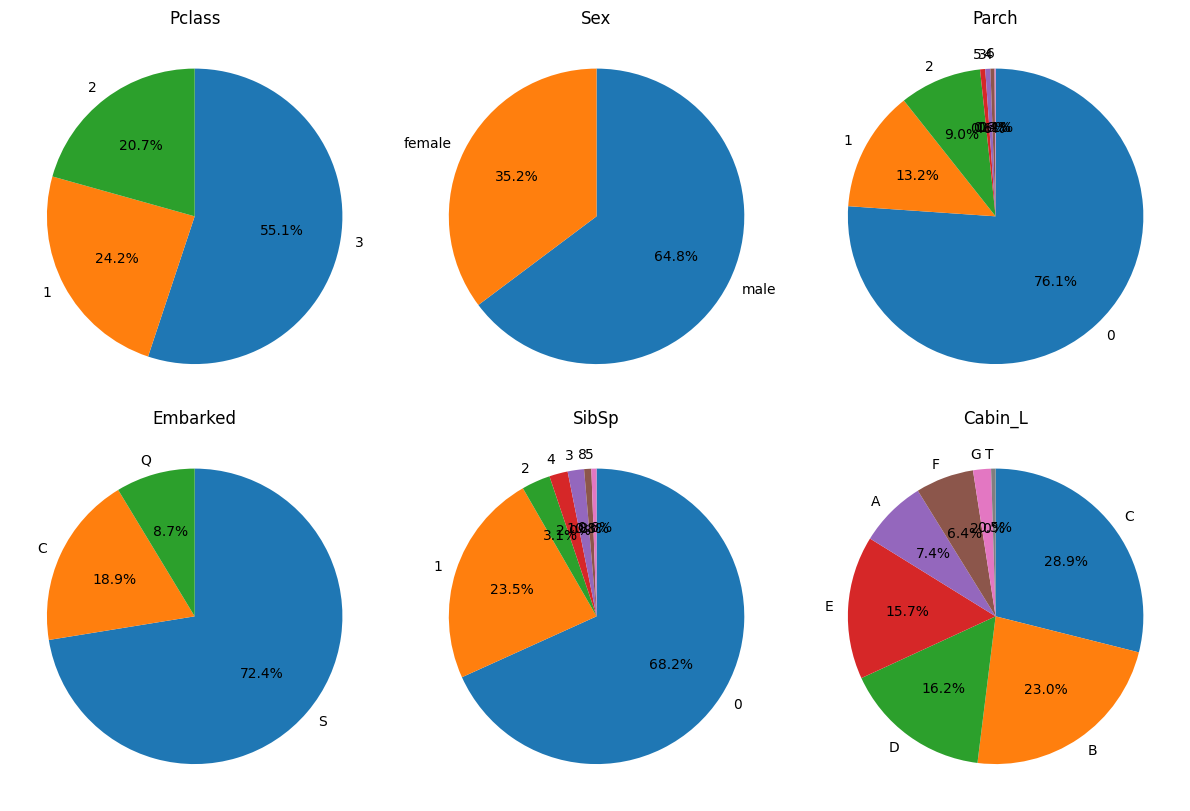

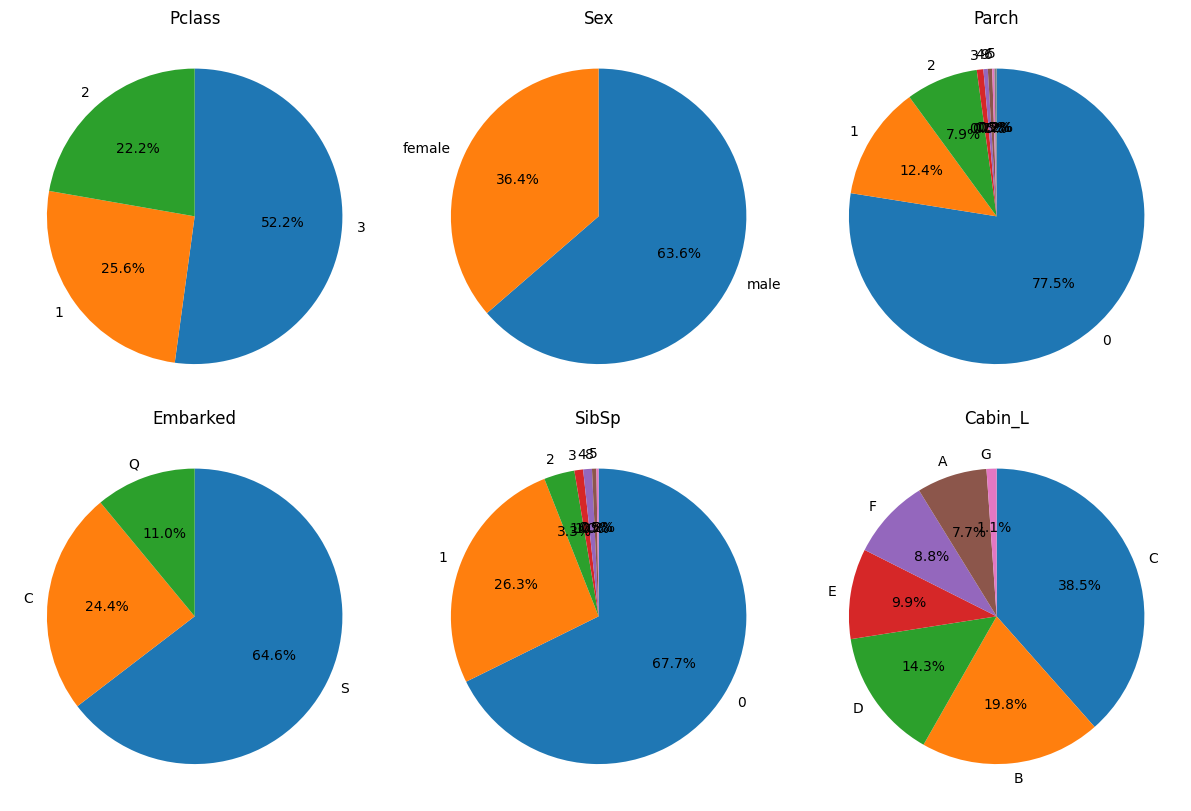

In [37]:
plot_cat_cols(train, cat_columns)
plot_cat_cols(test, cat_columns)

# Input to Output Diagrams (for Visualization Purposes)

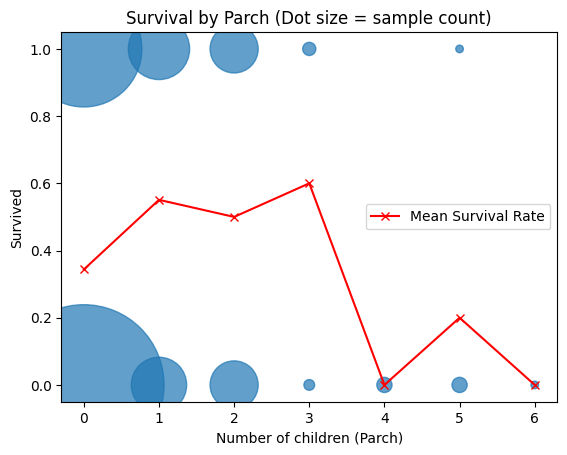

In [32]:
# Parch (Parent of number of children if I am not mistaken)  Plots

# Count occurence of each pair
counts = train.groupby(["Parch", "Survived"]).size().reset_index(name="count")

# Plot with dot size reflecting count
plt.scatter(counts["Parch"], counts["Survived"], s=counts["count"]*30, alpha=0.7)
plt.xlabel("Number of children (Parch)")
plt.ylabel("Survived")
plt.title("Survival by Parch (Dot size = sample count)")

# Calculate the mean of surival per Parch
means = []
parches = counts["Parch"].unique()
for parch in parches:
    total = (train["Parch"] == parch).sum()
    survived = train[(train["Parch"] == parch) & (train["Survived"] == 1)].shape[0]
    mean = survived / total if total > 0 else np.nan
    means.append(mean)

# Add a line to the graph
plt.plot(parches, means, color="red", marker="x", label="Mean Survival Rate")
plt.legend()
plt.show()

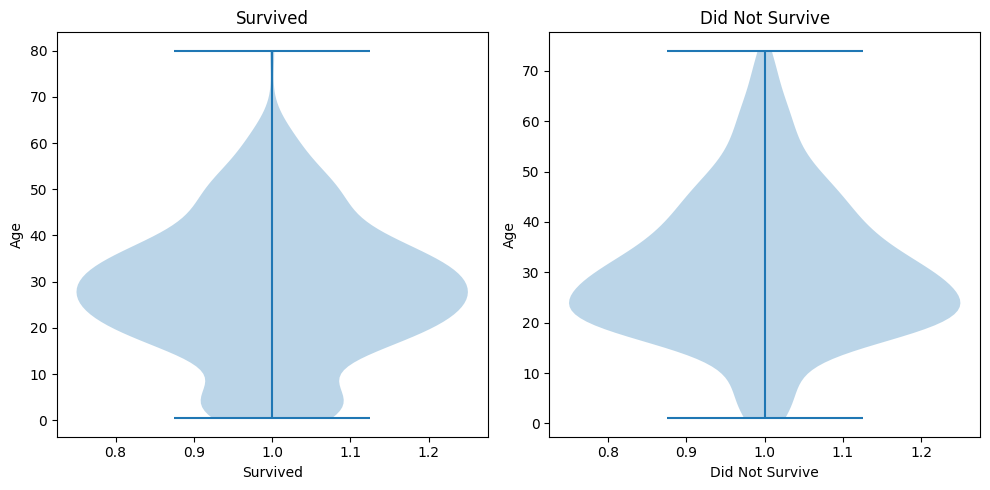

In [33]:
# Filter the data, dropping pd.<NA>s *before* plotting
survived_ages_data = train["Age"][train["Survived"] == 1].dropna()
dead_ages_data = train["Age"][train["Survived"] == 0].dropna()

survived_ages_list = survived_ages_data.tolist()
dead_ages_list = dead_ages_data.tolist()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Pass the lists to violinplot
axs[0].violinplot(survived_ages_list)
axs[0].set_title("Survived")
axs[0].set_xlabel("Survived")
axs[0].set_ylabel("Age")

axs[1].violinplot(dead_ages_list)
axs[1].set_title("Did Not Survive")
axs[1].set_xlabel("Did Not Survive")
axs[1].set_ylabel("Age")

plt.tight_layout()
plt.show()